In [54]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans, SpectralClustering
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')

In [2]:
bert_df = pd.read_csv('bert_embeddings.csv')

In [3]:
names = bert_df['name'].values
cuisines = bert_df['cuisines'].values
embeds_df = bert_df[['emb'+str(n) for n in range(bert_df.shape[1]-3)]]
embeds = embeds_df.values

names
cuisines
embeds

array([[-0.53110659,  2.62989306, -0.43897513, ..., -0.1998643 ,
         0.20708974, -2.69395232],
       [-0.2042311 , -0.18730775, -1.0520283 , ..., -0.18291491,
        -0.46647581, -0.57869595],
       [-0.31909713,  0.9721691 , -2.24729037, ..., -1.17822015,
         0.12798297, -0.63680685],
       ...,
       [ 0.29033819,  1.77179945,  0.61679405, ..., -0.81742603,
        -1.17893744, -2.57956886],
       [ 2.53623414, -1.24973178, -0.12850386, ...,  2.13055253,
         0.23436248, -1.62887383],
       [-0.29287159,  0.02978888, -0.8485359 , ...,  0.61290967,
         0.92072934,  0.08677696]])

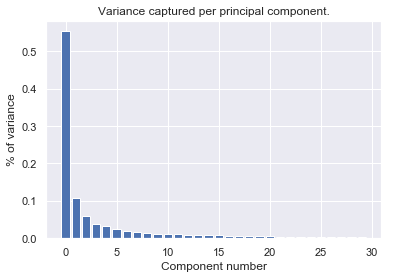

In [4]:
pca = PCA(n_components=30)
principal_components = pca.fit_transform(embeds)

pca0 = principal_components[:,0]
pca1 = principal_components[:,1]
pca2 = principal_components[:,2]

summed = sum(pca.explained_variance_)

plt.bar(range(len(pca.explained_variance_)),[i/summed for i in (pca.explained_variance_)])
plt.title('Variance captured per principal component.')
plt.ylabel('% of variance')
plt.xlabel('Component number')
plt.show()

# Comparison of clustering algorithms

In [5]:
from cluster_plot import plot_clusters, plot_label_dist, plot_3d_clusters

##### Kmeans++

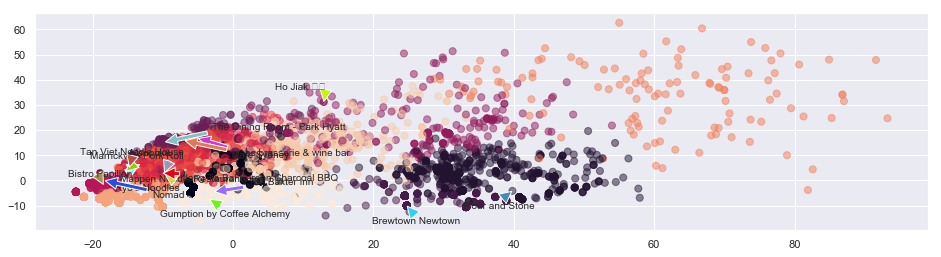

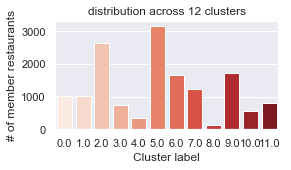

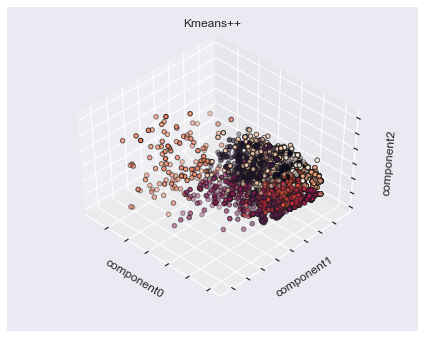

In [11]:
kplus = KMeans(n_clusters=12,init='k-means++').fit(embeds)

plot_clusters(kplus
              ,pc=principal_components
              ,text=True
              ,names=names
              ,n_names=15
              ,figsize=(16,4))

plot_label_dist(kplus,palette='Reds',figsize=(4,2))
plot_3d_clusters([('Kmeans++',kplus)],pc=principal_components,figsize=(6,4.5))

##### Affinity Propagation

##### Hierarchical (agglomerative) clustering

In [12]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, inconsistent
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist, cosine, euclidean

In [13]:
def minimal_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)
    city = kwargs["city"]
    del kwargs["city"]
    
    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram for {}'.format(city))
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

In [14]:
l = linkage(embeds, method='complete', metric='seuclidean')

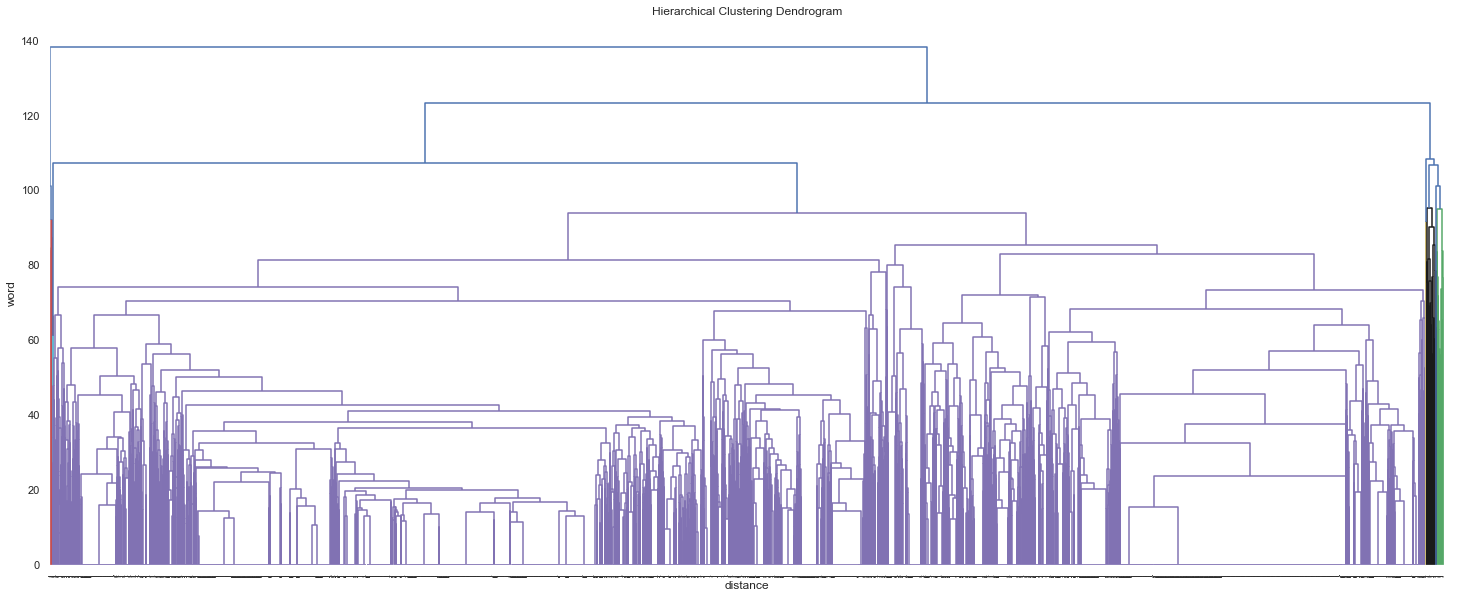

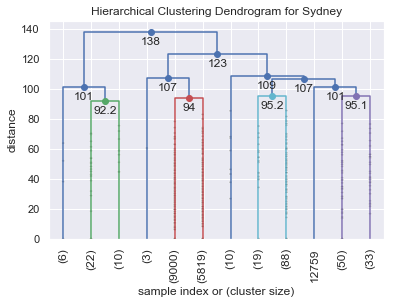

In [15]:
# calculate full dendrogram

plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.ylabel('word')
plt.xlabel('distance')

dendrogram(
    l,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=0.,  # font size for the x axis labels
    orientation='top',
)
plt.show()

minimal_dendrogram(
    l,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    city='Sydney'
)
plt.show()

#### Copheretic correlation

A statistic that measures how well the denodogram preserves pairwise relations between datapoints. Above 0.8 is a useful baseline.

For embeddings modelled with an hierarichal cluster method to produce a dendrogram $$X_i \longrightarrow T_i$$

we define the following distance measures for the ith and jth observations:

$$Euclid.dist\;=\; x(i, j)\; =\; | X_i − X_j |$$
$$Dendrog.dist\;=\;t(i, j)\; = var(min(C(i,j)))$$

where *t(i,j)* is the item-wise variance of the lowest cluster (via Ward's metric) that *i and j* co-inhabit.

Then, letting $$\bar{x} = \frac{\sum_{i=1}^nx(i, j)}{n}$$$$\bar{t} = \frac{\sum_{i=1}^nt(i,j)}{n}$$

the cophenetic correlation is equal to:

$$c = \frac{\sum_{i<j}(x(i,j)-\bar{x})(t(t,j)-\bar{t})}{\sqrt{[\sum_{i<j}(x(i,j)-\bar{x})^2][\sum_{i<j}(t(i,j)-\bar{t})^2]}}$$

.

###### As c approaches 1, the pairwise preservation improves.

In [17]:
corr, coph_dists = cophenet(l, pdist(embeds))
print('\nCophenetic correlation:', corr,'\n')


Cophenetic correlation: 0.7732857918181891 



Large clusters n:
8 

Medium clusters n:
35 

Small clusters n:
180 

Tiny clusters n:
712 



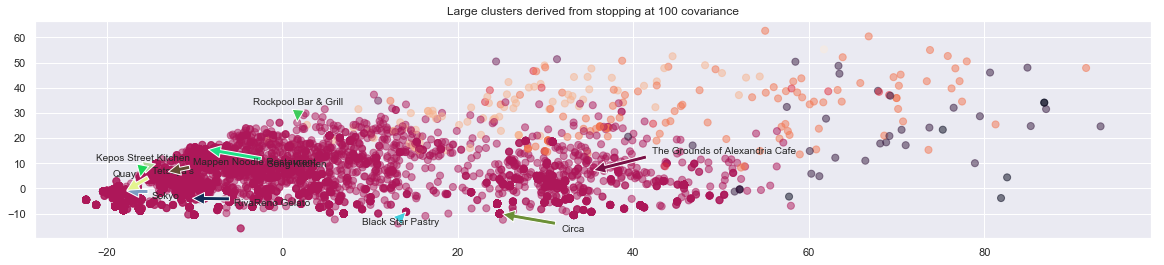

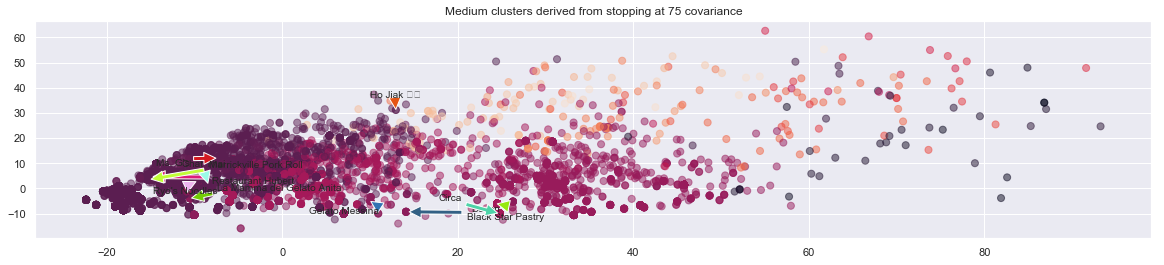

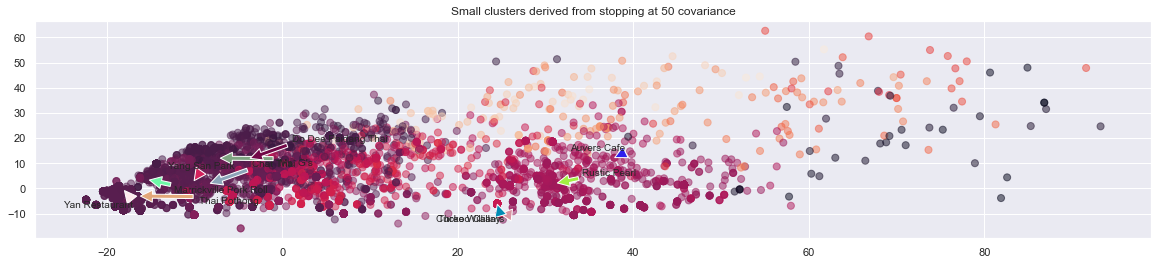

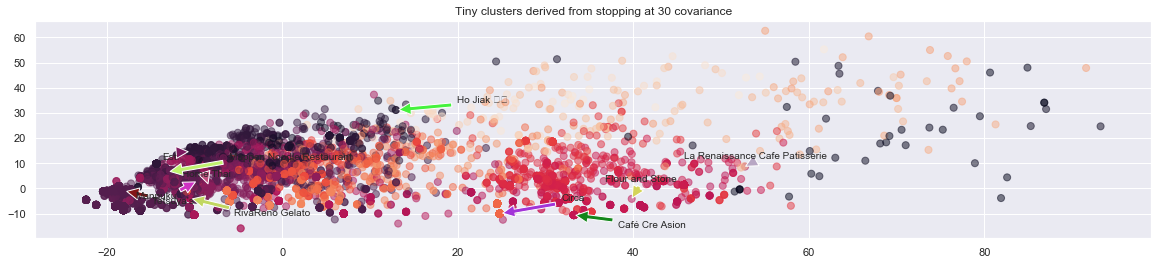

In [20]:
t_values = [('Large clusters',100),('Medium clusters',75),('Small clusters',50),('Tiny clusters',30)]

agglom_labels = []

for label, t_value in t_values:
    print(label,'n:')
    clusters = fcluster(l, t=t_value, criterion='distance')
    print(len(np.unique(clusters)),'\n')

    agglom_labels += [clusters]
    
agglom_labels = np.array(agglom_labels)


for i in range(len(agglom_labels)): 
    plot_clusters(l,pc=principal_components
                  ,labels=agglom_labels[i]
                  ,names=names
                  ,text=True,figsize=(20,4)
                  ,title=('{} derived from stopping at {} covariance'
                         ).format(t_values[i][0],t_values[i][1]))
    plt.show()

In [22]:
### Build a cluster labels dataframe

metadata_df = pd.DataFrame(zip(names,cuisines,principal_components[:,0],
                            principal_components[:,1],
                            principal_components[:,2])
                           ,columns=['name','cuisines','pca_0','pca_1','pca_2'])

metadata_df['agglomerative_l'] = agglom_labels[0]
metadata_df['agglomerative_m'] = agglom_labels[1]
metadata_df['agglomerative_s'] = agglom_labels[2]
metadata_df['agglomerative_t'] = agglom_labels[3]
metadata_df['kmeans++'] = kplus.labels_


embeddings_df = pd.DataFrame(embeds)
embeddings_df['name'] = names

In [30]:
def nearest_neighbours(embeddings,from_index=None,from_name=None,names=None,to_df=True,cos=True):
    
    if from_index==None and from_name!=None: from_index = names.index(from_name)
        
    from_emb = embeddings[from_index]
    from_name = names[from_index] if from_name==None else from_name
    
    if cosine: dist = lambda x: cosine(from_emb,x)
    else: dist = lambda x: euclidean(from_emb,x)
    
    nn = sorted([(to_name,dist(to_emb)) 
                     for to_emb,to_name 
                         in zip(embeddings,names)]
                
                ,key=lambda x:x[1]
                ,reverse=False)
    
    if to_df: nn = pd.DataFrame(nn,columns=['name','distance']).drop_duplicates()
    
    return from_name,nn



def meta_nearest_neighbours(metadata_df=metadata_df
                            ,embeddings=embeds
                            ,names=None
                            ,from_index=None
                            ,from_name=None):
    
    from_item, nn_df = nearest_neighbours(embeddings
                                         ,from_index=from_index
                                         ,from_name=from_name
                                         ,names=names
                                         ,to_df=True)
    
    return from_item, nn_df.merge(metadata_df
                        ).sort_values(by='distance'
                                 ).drop_duplicates(subset='name')
    
    

In [34]:
item,nn = meta_nearest_neighbours(from_name='Aqua S',names=list(names))

In [36]:
cluster_names = ['kmeans++'
                 ,'agglomerative_l','agglomerative_m'
                 ,'agglomerative_s','agglomerative_t']

print('Nearest neighbours for',item)

nn[['name',
    'agglomerative_l',
    'agglomerative_m',
    'agglomerative_s',
    'agglomerative_t',
    'kmeans++']].head(5)

Nearest neighbours for Aqua S


,name,agglomerative_l,agglomerative_m,agglomerative_s,agglomerative_t,kmeans++
0,Aqua S,4,13,64,316,11
39,Mövenpick Ice Cream,4,13,64,316,11
40,Cold Rock Ice Creamery,4,13,64,316,11
44,Bannos Brownies,4,13,64,316,11
46,Gelato Tesoro,4,13,64,316,11


# Evaluation

###### NDCG @k (Normalized-discounted Culumative gain)


https://hivemall.incubator.apache.org/userguide/eval/rank.html

In [47]:
import math
from collections import defaultdict


def ndcg(ranking
         ,cluster_cardinality
         ,binary=True
         ,receptive_field=1):
    
    dcg = lambda x: sum([rel/math.log(pos+2) for pos,rel in enumerate(x)])
    
    n = len(ranking) if (len(ranking) < cluster_cardinality) else cluster_cardinality
    
    actual_dcg = dcg(ranking)
    ideal_dcg = dcg([1] * n)
    normalized_dcg = actual_dcg / ideal_dcg
    
    return normalized_dcg


def rank_scores(item
                ,nn
                ,binarize=True
                ,k=10
                ,cluster_names=cluster_names):
    """
    Input: 
        nearest neighbours dataframe,
        k to represent size of list.
    
    Returns:
        A binarized ranking, where 1 is assigned to
    entries with matching clusters, and 0 otherwise.
    """
    
    rankings = {}
    
    nn.sort_values(by='distance')
    from_item = nn[nn.name==item]
    nn = nn[nn.name!=item]
    
    binarizer = lambda x:1 if x==0 else 0
    
    for c in cluster_names:
        n_clusters = len(set(nn[c].values))
        clusters = nn[c].values[:k]
        ground_truth = int(from_item[c])
        ground_size = nn[nn[c]==ground_truth].shape[0]
        
        continuous = [( abs(ground_truth - c) / ground_truth )
                        for c in list(clusters)]
        
        binarized = [binarizer(ground_truth-c) for c in clusters]
        
        rankings[c] = binarized if binarize else continuous
    
    return rankings


def evaluate(k
             ,names=None
             ,metric='ndcg'
             ,stop_at=50
             ,binary=True
             ,cluster_names=cluster_names):
    
    rankings = []
    
    for n in names[:stop_at]:
        item, nn = meta_nearest_neighbours(from_name=n,names=names)
        rankings += [(n,nn[nn.name==item],nn,rank_scores(item,nn,binarize=binary,k=k))]
    
    rows = []
    count = 0

    for n,item,nn,cluster_rankings in rankings:
        metrics = []
        
        for c in cluster_rankings.keys():
            ranking = cluster_rankings[c]
            cardinality = nn[nn[c]==item[c].values[0]].shape[0]
            metrics += [ndcg(ranking,cardinality)]
        
        metrics = [n] + metrics
        rows += [tuple(metrics)]
        
    metric_df = pd.DataFrame(rows,columns=['name'] + cluster_names)
    return metric_df

In [50]:
def results(top_k=20,stop_at=5,names=names):
    n_results = []
    b_results = []

    for i in range(1,top_k):
        print('{} of {} iterations complete...'.format(i-1,top_k))
        binary_df = evaluate(i,binary=True,names=list(names),stop_at=stop_at).drop('name',axis=1)
        normalized_df = evaluate(i,binary=False,names=list(names),stop_at=stop_at).drop('name',axis=1)

        b_results += [binary_df.apply(np.mean,axis=0).values]
        n_results += [normalized_df.apply(np.mean,axis=0).values]

        header = binary_df.apply(np.mean,axis=0).index

    binary_results = pd.DataFrame(b_results,columns=header)
    normalized_results = pd.DataFrame(n_results,columns=header)

    return [('binary',binary_results),('normalized',normalized_results)]

In [51]:
data = results(top_k=10,stop_at=100,names=list(names))

0 of 10 iterations complete...
1 of 10 iterations complete...
2 of 10 iterations complete...
3 of 10 iterations complete...
4 of 10 iterations complete...
5 of 10 iterations complete...
6 of 10 iterations complete...
7 of 10 iterations complete...
8 of 10 iterations complete...


In [52]:
data[0][1].to_csv('ndcg_binary.csv')

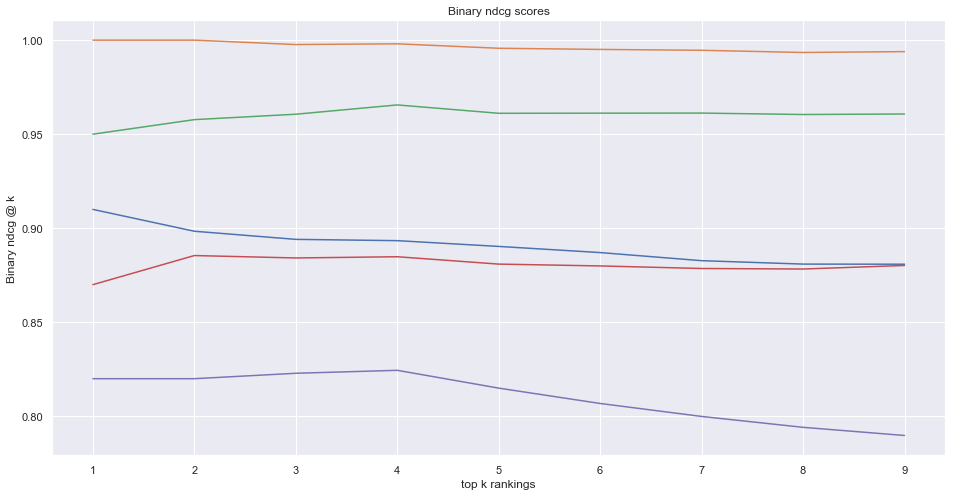

,kmeans++,agglomerative_l,agglomerative_m,agglomerative_s,agglomerative_t
0,0.910000,1.000000,0.950000,0.870000,0.820000
1,0.898394,1.000000,0.957737,0.885474,0.820000
2,0.894078,0.997654,0.960614,0.884190,0.822877
3,0.893393,0.998048,0.965555,0.884839,0.824455
4,0.890323,0.995680,0.961111,0.880922,0.814983
5,0.887055,0.995068,0.961172,0.879949,0.806821
6,0.882743,0.994604,0.961219,0.878589,0.799928
7,0.880929,0.993438,0.960458,0.878311,0.794143
8,0.880863,0.993903,0.960734,0.880204,0.789804


In [53]:
X = range(1,10)

plt.figure(figsize=(16,8))

for Y in cluster_names:
    if Y=='affinity_propagation': pass
    else:
        sns.lineplot(y=Y,x=X,data=data[0][1],legend='full'
                        ).set(xlabel='top k rankings'
                             ,ylabel='Binary ndcg @ k'
                             ,title='Binary ndcg scores')

plt.show()

data[0][1]